<a href="https://colab.research.google.com/github/Y3JUN/Y3JUN.github.io/blob/master/Neighbor_Joining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 65.7 MB/s eta 0:00:00


Phylogenetic Tree (Newick Format): ((Group 2,((Group 4,(Group 4,Group 4)),((((Group 4,(Group 3,(Group 1,Group 3))),((Group 2,(Group 2,Group 5)),((Group 5,(Group 4,(Group 3,Group 5))),(Group 3,Group 3)))),((Group 5,Group 5),(Group 3,Group 3))),(Group 5,(((Group 1,(Group 1,Group 1)),((Group 1,Group 4),(Group 2,(Group 3,Group 5)))),((Group 1,Group 4),(((Group 1,Group 2),(Group 3,Group 5)),(Group 5,(Group 2,(Group 4,Group 3)))))))))),((Group 4,((Group 4,Group 2),(Group 2,(Group 1,Group 1)))),((Group 1,Group 5),(Group 2,Group 2))))


<Figure size 1500x1000 with 0 Axes>

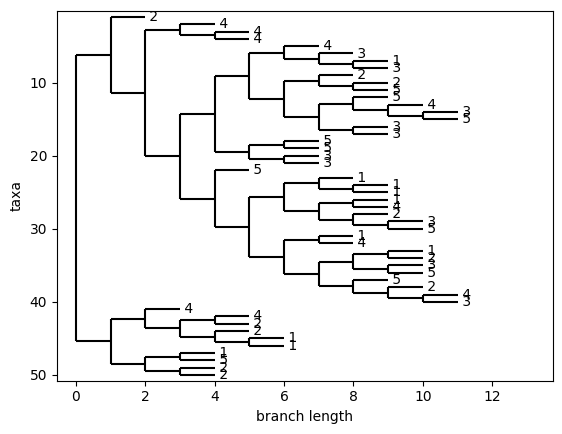

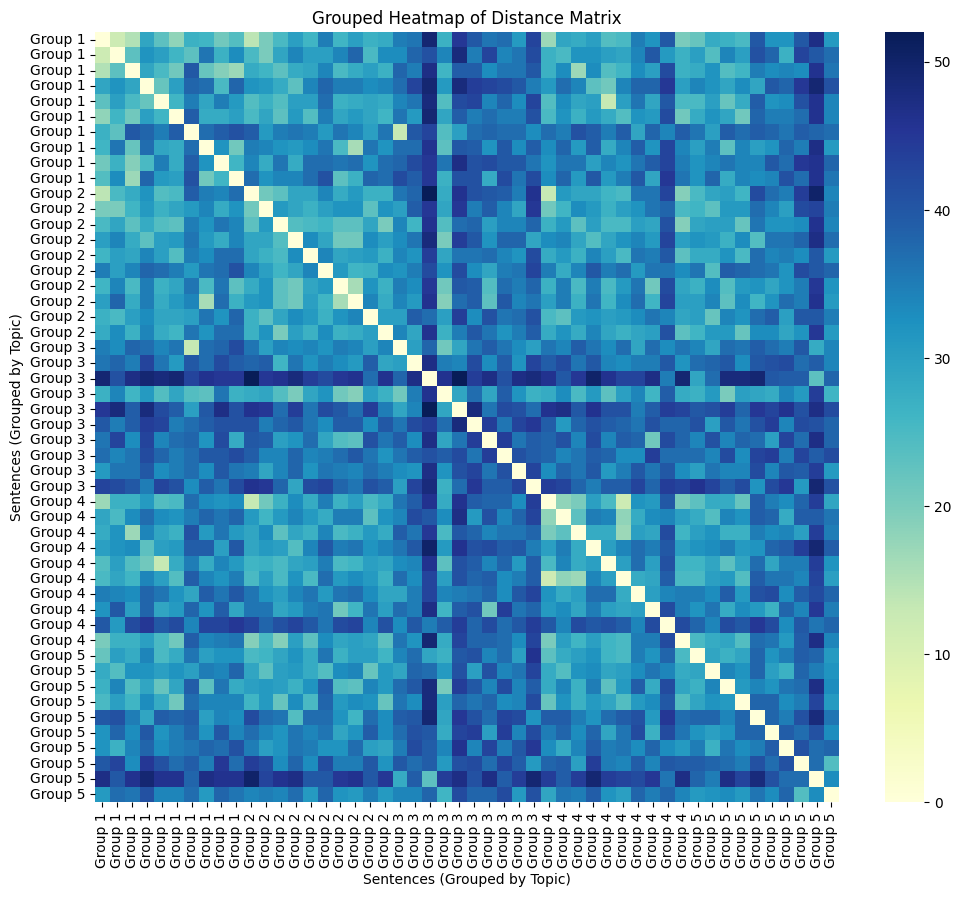

Silhouette Score: 0.13126633492334586


In [5]:
import json
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from Bio import Phylo
from io import StringIO
import seaborn as sns

file_path = '/content/test.json'
with open(file_path, 'r') as f:
    data = json.load(f)

def extract_strings_with_labels(nested_structure, parent_key=""):
    strings = []
    if isinstance(nested_structure, dict):
        for key, value in nested_structure.items():
            new_key = f"{parent_key}/{key}" if parent_key else key
            strings.extend(extract_strings_with_labels(value, new_key))
    elif isinstance(nested_structure, list):
        for item in nested_structure:
            strings.append((item, parent_key))
    return strings

strings_with_labels = extract_strings_with_labels(data)
strings = [s[0] for s in strings_with_labels]
labels = [s[1] for s in strings_with_labels]

# Map topics to group numbers
unique_topics = sorted(set(labels))
topic_to_group = {topic: f"Group {i + 1}" for i, topic in enumerate(unique_topics)}
grouped_labels = [topic_to_group[label] for label in labels]

# Step 1: Compute the distance matrix using edit distance
def edit_distance(s1, s2):
    len_s1, len_s2 = len(s1), len(s2)
    dp = np.zeros((len_s1 + 1, len_s2 + 1), dtype=int)

    for i in range(len_s1 + 1):
        dp[i][0] = i
    for j in range(len_s2 + 1):
        dp[0][j] = j

    for i in range(1, len_s1 + 1):
        for j in range(1, len_s2 + 1):
            cost = 0 if s1[i - 1] == s2[j - 1] else 1
            dp[i][j] = min(
                dp[i - 1][j] + 1,       # Deletion
                dp[i][j - 1] + 1,       # Insertion
                dp[i - 1][j - 1] + cost # Substitution
            )

    return dp[len_s1][len_s2]

if len(strings) < 3:
    raise ValueError("Neighbor joining requires at least three strings in the dataset.")

n = len(strings)
dist_matrix = np.zeros((n, n))
for i in range(n):
    for j in range(i + 1, n):
        dist = edit_distance(strings[i], strings[j])
        dist_matrix[i, j] = dist
        dist_matrix[j, i] = dist

# Step 2: Implement Neighbor Joining Algorithm
class NeighborJoining:
    def __init__(self, dist_matrix, labels):
        self.dist_matrix = dist_matrix
        self.labels = labels
        self.n = len(labels)

    def compute_q_matrix(self):
        n = self.n
        q_matrix = np.full((n, n), np.inf)
        for i in range(n):
            for j in range(i + 1, n):
                q_matrix[i, j] = (n - 2) * self.dist_matrix[i, j] - np.sum(self.dist_matrix[i, :]) - np.sum(self.dist_matrix[:, j])
                q_matrix[j, i] = q_matrix[i, j]
        return q_matrix

    def find_min_q(self, q_matrix):
        return np.unravel_index(np.argmin(q_matrix), q_matrix.shape)

    def update_distance_matrix(self, i, j):
        new_distances = []
        for k in range(self.n):
            if k != i and k != j:
                new_dist = (self.dist_matrix[i, k] + self.dist_matrix[j, k] - self.dist_matrix[i, j]) / 2
                new_distances.append(new_dist)
        new_dist_matrix = np.delete(self.dist_matrix, [i, j], axis=0)
        new_dist_matrix = np.delete(new_dist_matrix, [i, j], axis=1)
        new_dist_matrix = np.vstack([new_dist_matrix, new_distances])
        new_distances.append(0)
        new_dist_matrix = np.hstack([new_dist_matrix, np.array(new_distances).reshape(-1, 1)])
        return new_dist_matrix

    def build_tree(self):
        labels = self.labels[:]
        while len(labels) > 2:
            q_matrix = self.compute_q_matrix()
            i, j = self.find_min_q(q_matrix)
            new_label = f"({labels[i]},{labels[j]})"
            labels.append(new_label)
            self.dist_matrix = self.update_distance_matrix(i, j)
            labels.pop(max(i, j))
            labels.pop(min(i, j))
            self.n -= 1
        return f"({labels[0]},{labels[1]})"

# Run Neighbor Joining
nj = NeighborJoining(dist_matrix, grouped_labels)
phylogenetic_tree = nj.build_tree()
print("Phylogenetic Tree (Newick Format):", phylogenetic_tree)

# Visualize the Tree using Bio.Phylo
plt.figure(figsize=(15, 10))
handle = StringIO(phylogenetic_tree)
tree = Phylo.read(handle, "newick")
Phylo.draw(tree, label_func=lambda x: x.name.split('/')[-1] if x.name else x.name)
plt.show()

# Grouped Heatmap
sorted_indices = sorted(range(len(grouped_labels)), key=lambda i: grouped_labels[i])
sorted_dist_matrix = dist_matrix[np.ix_(sorted_indices, sorted_indices)]
sorted_labels = [grouped_labels[i] for i in sorted_indices]

plt.figure(figsize=(12, 10))
sns.heatmap(
    sorted_dist_matrix,
    xticklabels=sorted_labels,
    yticklabels=sorted_labels,
    cmap="YlGnBu",
    annot=False
)
plt.title("Grouped Heatmap of Distance Matrix")
plt.xlabel("Sentences (Grouped by Topic)")
plt.ylabel("Sentences (Grouped by Topic)")
plt.show()

# Step 3: Evaluate the Clustering
clustering = AgglomerativeClustering(n_clusters=3, metric='precomputed', linkage='average')
hclust_labels = clustering.fit_predict(dist_matrix)

# at least two distinct clusters
if len(set(hclust_labels)) > 1:
    # Compute silhouette score
    sil_score = silhouette_score(dist_matrix, hclust_labels, metric='precomputed')
    print("Silhouette Score:", sil_score)
else:
    print("Silhouette Score cannot be computed: Only one cluster detected.")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')